# Finance 5350 

__Computational Financial Modeling__

## Simulating Spot Price Dynamics

We can use the simplified setting of the binomial model to build an intuition for how the Black-Scholes model is derived. We start by simulating prices paths in the binomial model and storing them in a Numpy array. 

In [9]:
%matplotlib inline

In [10]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
def callPayoff(spot, strike):
    return np.maximum(spot - strike, 0.0)

def putPayoff(spot, strike):
    return np.maximum(strike - spot, 0.0)

In [12]:
def AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps):
    paths = np.empty((nreps, nsteps + 1))
    h = expiry / nsteps
    u = np.exp((mu - div) * h + sigma * np.sqrt(h))
    d = np.exp((mu - div) * h - sigma * np.sqrt(h))
    p = (np.exp((mu - div) * h) - d) / (u - d)
    paths[:,0] = spot

    for i in range(nreps):
        w = np.random.uniform(size=nsteps)
        for j in range(nsteps):
            if w[j] >= p: 
                paths[i, j + 1] = paths[i, j] * u
            else:
                paths[i, j + 1] = paths[i, j] * d

    return paths

Let's set up some basic data and look at the generated paths. 

In [17]:
### Basic Data
spot = 100.0
mu = 0.10     ## notice that we are simulating the physical price here! (to simulate the risk-neutral price just use $r$)
sigma = 0.30
expiry = 1.0
div = 0.0
nreps = 10000
nsteps = 252 # 252 trading days in a year, 13.5 open trading hours, 4 15-minute periods in an hour

### Get Paths and Plot One of Them 
paths = AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps)

In [18]:
paths

array([[100.        , 101.94824016, 100.07939658, ..., 128.45290311,
        126.09819466, 123.78665107],
       [100.        ,  98.1668702 ,  96.36734404, ..., 161.1508702 ,
        158.19676557, 161.27881849],
       [100.        , 101.94824016, 103.93443671, ...,  75.67229143,
         77.1465694 ,  78.64956985],
       ...,
       [100.        , 101.94824016, 103.93443671, ...,  94.93483852,
         96.78439717,  98.66998966],
       [100.        , 101.94824016, 103.93443671, ..., 167.35837237,
        170.61891538, 173.94298161],
       [100.        , 101.94824016, 103.93443671, ..., 102.38944597,
        104.38423827, 102.47073969]])

### Plotting a Price Path with Matplotlib

This is helpful, but it would be much nicer to visualize an entire price path evolution. For this we will use `matplotlib` for plotting. 

In [19]:
def plotPricePath(path):
    nsteps = path.shape[0]
    plt.plot(path, 'b', linewidth = 2.5)
    plt.title("Simulated Binomial Price Path")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Price ($)")
    plt.xlim((0, nsteps))
    plt.grid(True)
    plt.show()

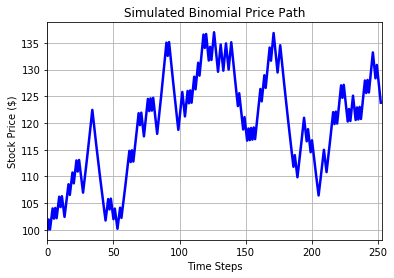

In [20]:
plotPricePath(paths[0])

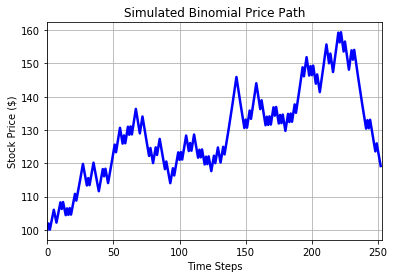

In [21]:
plotPricePath(paths[9])

This is indeed helpful to visualize price dynamics. (And to give us a little faith in the ability of the simple binomial model to generalize).

<br>

Let's also see how to plot a histogram of the spot price at expiry ($S_{T}$) of many simulated price paths. 

In [22]:
def plotHist(data):
    n, bins, patches = plt.hist(data, 50, density=True, facecolor = 'b', alpha=0.75)
    plt.title('Histogram of Spot Prices at Expiry')
    plt.xlabel('Spot Prices at Expiry')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

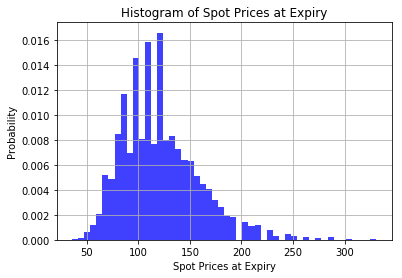

In [23]:
nreps = 5000
paths = AssetPaths(spot, mu, sigma, expiry, div, nreps, nsteps)
spotT = paths[:, -1:]
plotHist(spotT)

It isn't obvious at this point, but we will discuss later in the BSM model context how this is a binomial approximation to a log-normal distribution for prices. 

<br>

Just a quick note:

- If $\ln{x} \sim N(\mu, \sigma)$

- Then $x \sim LN(m, v)$ (don't worry about $m$ and $v$ for now)

This is always counterintuitive for me. 

<br>

## The Delta-Hedging Market Maker

In the derivation of their seminal model Black-Scholes-Merton hypothesized a delta-hedging market maker. The market maker is an ___options manufacturer___ in their model. When a customer arrives to purchase an option (at the market maker's offer price) the market maker writes the option. The purchaser of the option holds the right to exercise. If she does, then the market maker is obligated. The only way the market maker is released from this obligation is if the option remains unexercised. 

<br>

Remember that the __market maker is in the moving business, and not the storage business!__. This means that he wishes to buy (at his bid) and sell (at his ask) as much as possible back to back to collect the spread. He is not in the business of speculation. He would like to have a market-neutral trading strategy so that he will not be subject to market risk. This can only happen if he has a _flat book_. That is if he is able to buy as many options as he sells (for each pair collecting the bid-ask spread as his compensation). But the problem is that he is not a direct intermediary. That is, it almost never happens that a buyer shows up simultaneously with a seller. He has to match them intertemporally, floating the resulting market risk as he does so. 

<br>

What BSM assume is that in order to protect himself from market risk he will dynamically hedge to synthetically create a market-neutral book. Let's look at the perspective of a market maker is has written a single call option (short one call option). In this case the opposite of a short call option is a long position in the synthetically created hedging portfolio:

$$
\Delta S_{t} + B
$$

In this portfolio the option market maker borrows $B$ and purchases $\Delta$ shares of stock (recall that we are assuming the possbility of fractional shares). Each time the stock price changes from $S_{t}$ to $S_{t+h}$ the market maker must rebalance the hedging portfolio from $\Delta_{t}$ to $\Delta_{t+h}$. Notice that this must happen in discrete time and with a lag in a real-world setting. 

<br>

Recall that we set:

$$
\Delta_{t} = e^{-\delta h} \left[\frac{f_{u} - f_{d}}{S_{t}(u - d)}\right]
$$

<br>

and

$$
B_{t} = e^{-r h} \left[\frac{u f_{d} - d f_{u}}{(u - d)}\right]
$$

<br>

where $f_{u}$ and $f_{d}$ are the values of the call or put option in the up and down states respectively, and $S_{t}$ is the spot price at time $t$. 

<br>

Given our ability to simulate a price path from the binomial model, we should be able to use the formula for $\Delta_{t}$ to simulate the process of dynamic delta-hedging in this simplified world. 

<br>

To get started with this, we require a function to compute $\Delta_{t}$ at a given time step. Let's see how this works:


In [43]:
def binomialDelta(spot, strike, rate, vol, expiry, div, nsteps, payoff):
    h = expiry / nsteps
    u = np.exp((rate - div) * h + vol * np.sqrt(h))
    d = np.exp((rate - div) * h - vol * np.sqrt(h))
    fu = payoff(spot * u, strike)
    fd = payoff(spot * d, strike) 
    delta = np.exp(-div * h) * ((fu - fd) / (spot * (u - d)))

    return delta


Note that the only thing that really changes as the price path evolves is the price itself. Everything else in our simplified economy is static. We are assuming here that we are hedging a call option, so will again use polymorphism and pass the function `callPayoff` as the `payoff`.

<br>

We can use Python's duck typing here to get a vectorized function to get all delta's on the price path at once. 

In [49]:
## Recall our basic setup
mu = 0.10     ## notice that we are simulating the physical price here! 
sigma = 0.30
expiry = 1.0
div = 0.0
nreps = 10
nsteps = int(252 * 13.5 * 4)
strike = 95.0
rate = 0.08

delta = binomialDelta(paths[9], strike, rate, sigma, expiry, div, nsteps, callPayoff)

In [50]:
delta[0]

1.0000000000000018

In [51]:
delta[-10:]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [52]:
np.min(delta)

0.9999999999999596

In [53]:
np.max(delta)

1.0000000000000402